In [1]:
# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Colab Notebooks/Sea Animal Classification Dataset/Sea Animals Dataset.zip"
extract_path = "/content/sea_animals"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

for root, dirs, files in os.walk(extract_path):
    print("Detected folders:", dirs)
    break

Detected folders: ['Sea Rays', 'Whale', 'Sharks', 'Turtle_Tortoise', 'Penguin', 'Squid', 'Nudibranchs', 'Octopus', 'Eel', 'Fish', 'Jelly Fish', 'Sea Urchins', 'Shrimp', 'Crabs', 'Corals', 'Seal', 'Puffers', 'Lobster', 'Dolphin', 'Starfish', 'Clams', 'Otter', 'Seahorse']


In [10]:
dataset_path = "/content/sea_animals"
categories = os.listdir(dataset_path)
print("Detected Classes:", categories)


Detected Classes: ['Sea Rays', 'Whale', 'Sharks', 'Turtle_Tortoise', 'Penguin', 'Squid', 'Nudibranchs', 'Octopus', 'Eel', 'Fish', 'Jelly Fish', 'Sea Urchins', 'Shrimp', 'Crabs', 'Corals', 'Seal', 'Puffers', 'Lobster', 'Dolphin', 'Starfish', 'Clams', 'Otter', 'Seahorse']


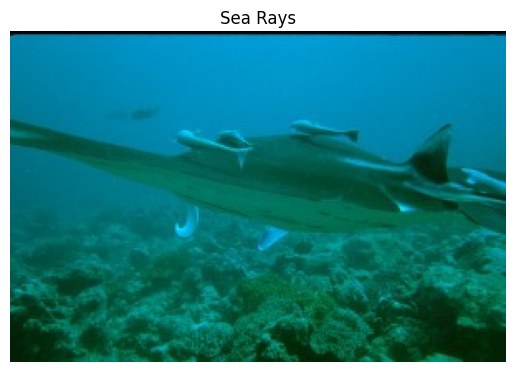

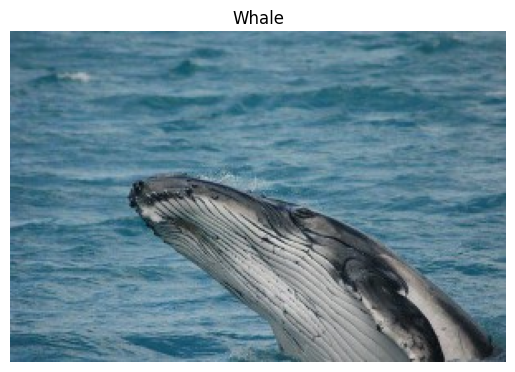

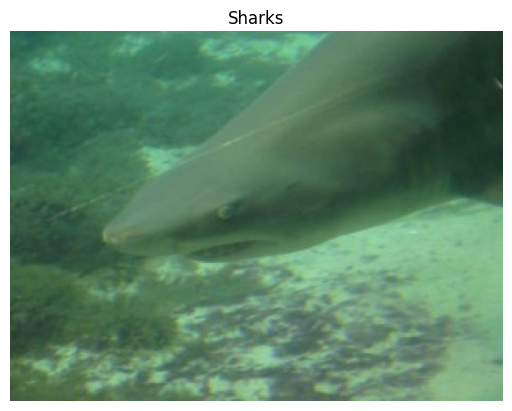

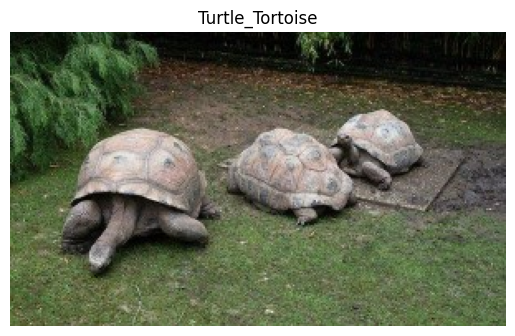

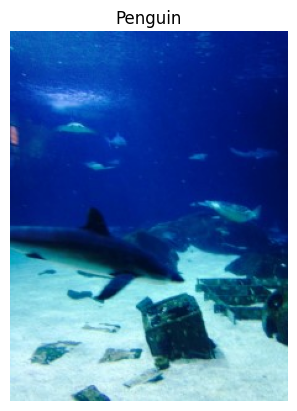

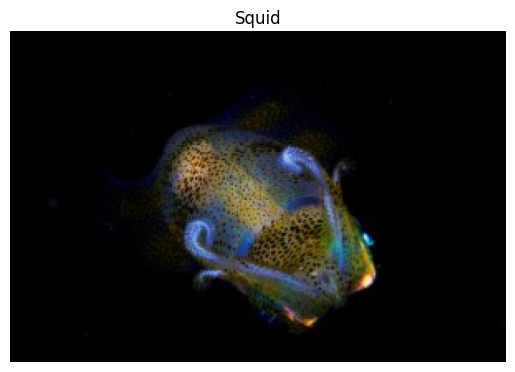

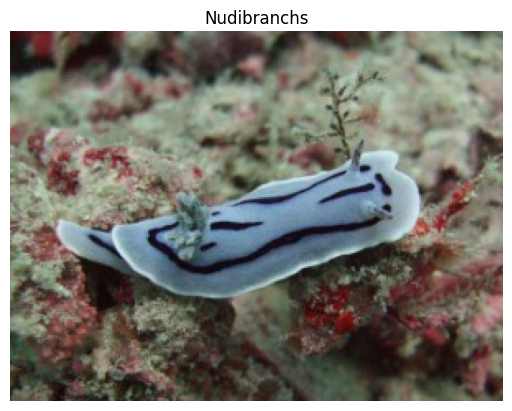

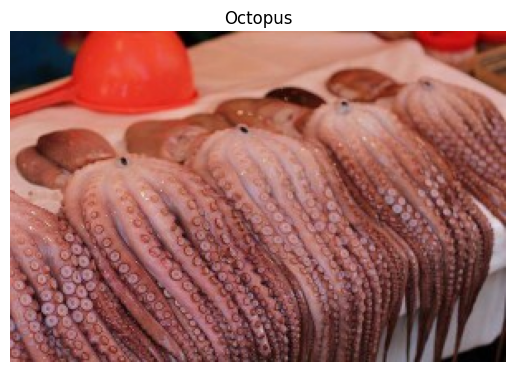

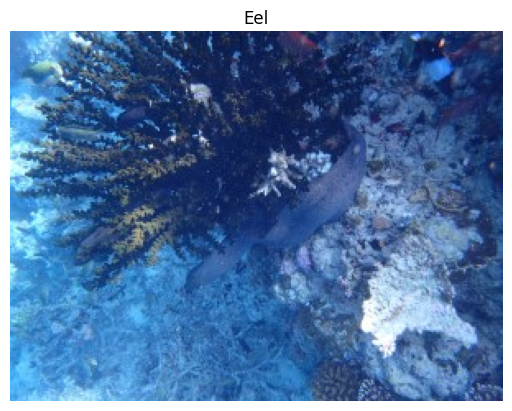

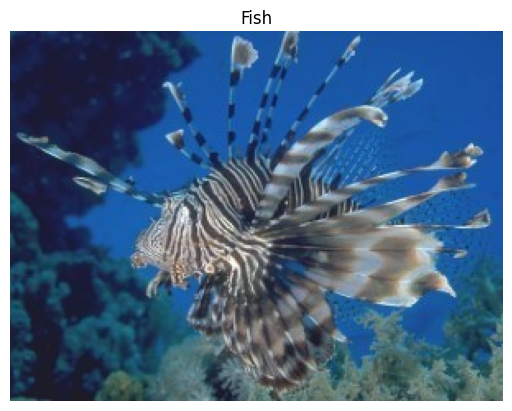

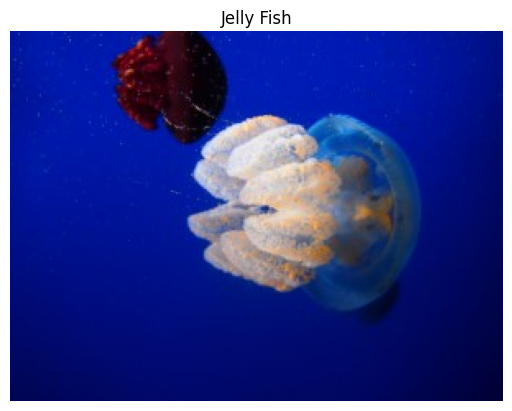

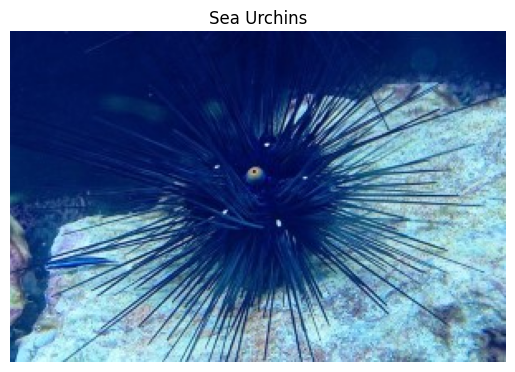

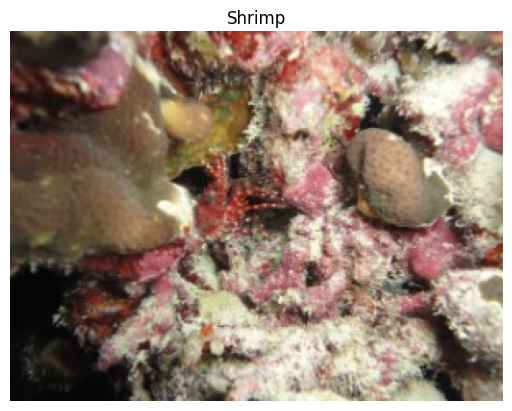

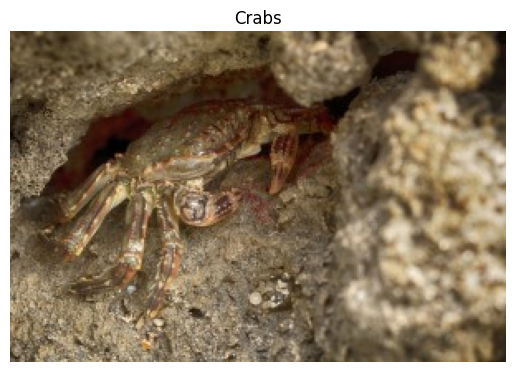

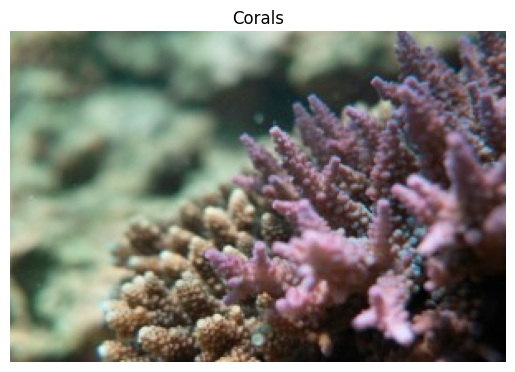

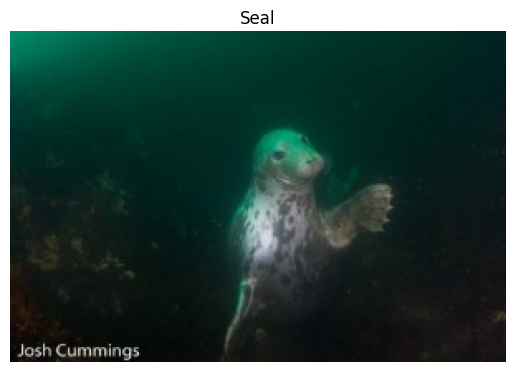

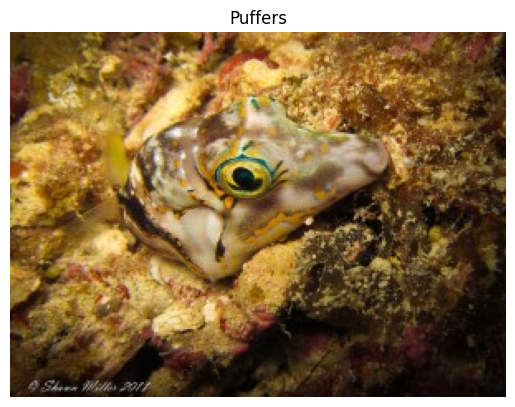

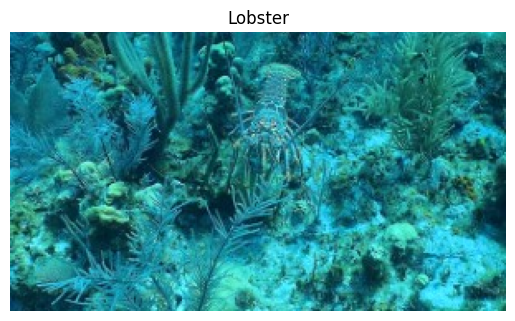

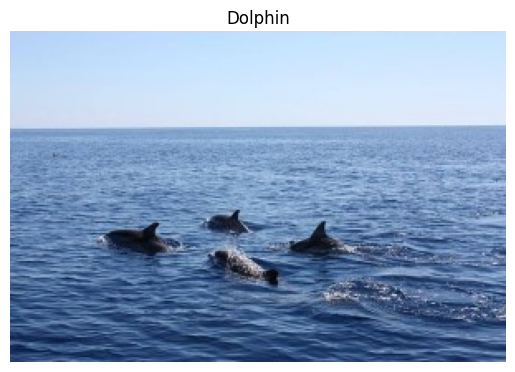

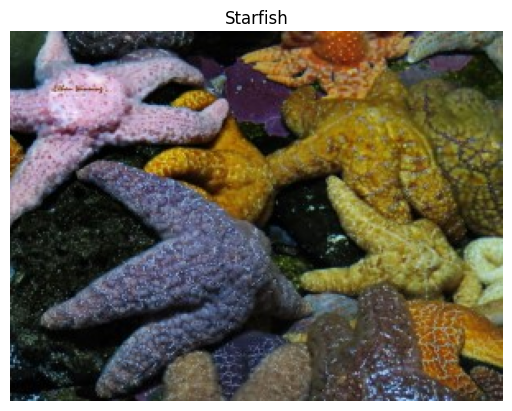

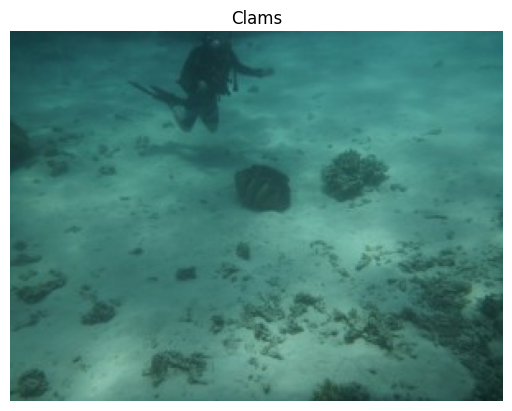

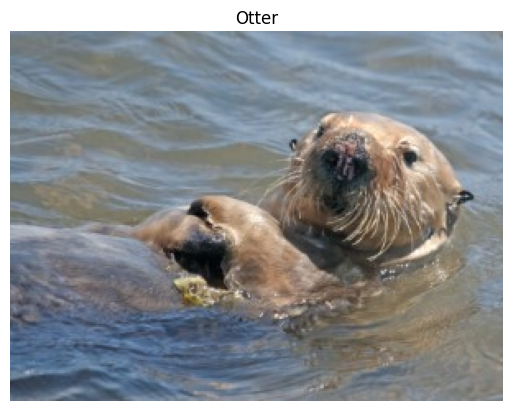

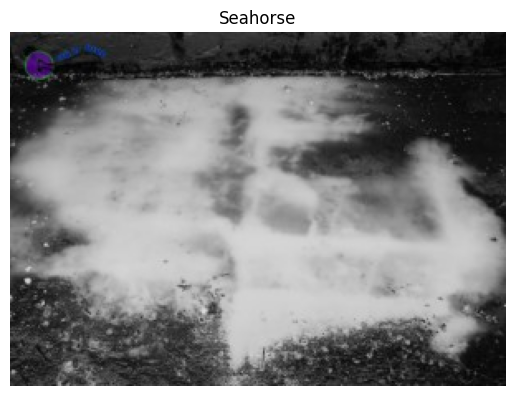

In [11]:
# Show one sample image per category
for category in categories:
    img_folder = os.path.join(dataset_path, category)
    img_file = os.listdir(img_folder)[0]
    img_path = os.path.join(img_folder, img_file)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
    plt.show()

In [12]:
# Image feature extraction
def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8,8,8], [0, 256, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten()

def extract_lbp(image_gray):
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image_gray, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_hu_moments(image_gray):
    moments = cv2.moments(image_gray)
    hu_moments = cv2.HuMoments(moments).flatten()
    return hu_moments

In [16]:
# Preprocess images and Extract features
from tqdm import tqdm
image_size = (128, 128)
X = []
y = []

def extract_color_histogram(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten()

def extract_lbp_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 10),
                             range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()
    return hu

categories = os.listdir(extract_path)

for category in tqdm(categories):
    folder = os.path.join(extract_path, category)
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        image = cv2.imread(file_path)
        if image is None:
            continue
        image = cv2.resize(image, image_size)

        color_features = extract_color_histogram(image)
        lbp_features = extract_lbp_features(image)
        shape_features = extract_hu_moments(image)

        features = np.hstack([color_features, lbp_features, shape_features])
        X.append(features)
        y.append(category)

100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


In [18]:
# Encode labels and Split data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X = np.array(X)
y_encoded = np.array(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

🔹 Training SVM
                 precision    recall  f1-score   support

          Clams       0.28      0.24      0.26       149
         Corals       0.22      0.23      0.23       150
          Crabs       0.45      0.38      0.41       150
        Dolphin       0.28      0.52      0.37       235
            Eel       0.16      0.07      0.10       149
           Fish       0.09      0.04      0.06       148
     Jelly Fish       0.57      0.58      0.58       253
        Lobster       0.17      0.15      0.16       150
    Nudibranchs       0.28      0.25      0.26       150
        Octopus       0.16      0.10      0.12       169
          Otter       0.46      0.54      0.50       150
        Penguin       0.22      0.20      0.21       145
        Puffers       0.14      0.06      0.08       159
       Sea Rays       0.18      0.14      0.16       155
    Sea Urchins       0.39      0.30      0.34       174
       Seahorse       0.35      0.11      0.17       143
           Seal

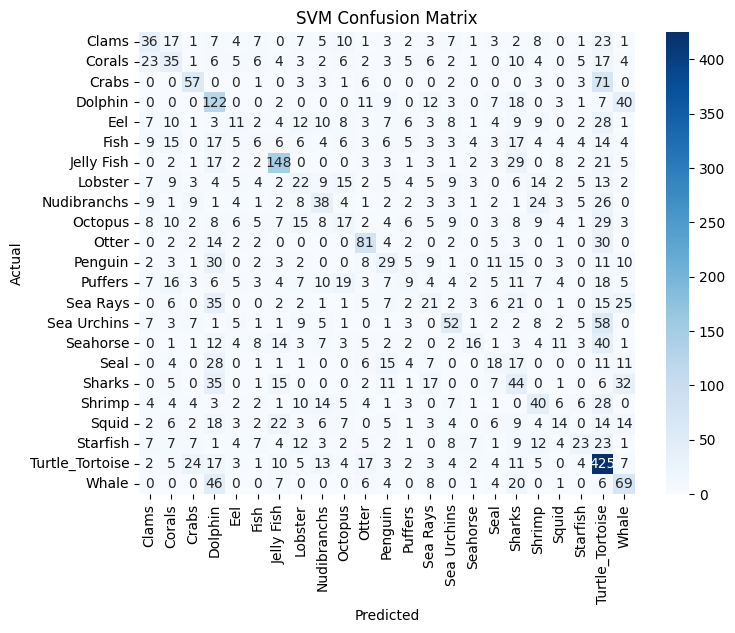

🔹 Training Random Forest
                 precision    recall  f1-score   support

          Clams       0.21      0.24      0.23       149
         Corals       0.25      0.29      0.26       150
          Crabs       0.49      0.51      0.50       150
        Dolphin       0.38      0.58      0.46       235
            Eel       0.13      0.09      0.11       149
           Fish       0.16      0.08      0.11       148
     Jelly Fish       0.60      0.71      0.65       253
        Lobster       0.20      0.17      0.18       150
    Nudibranchs       0.27      0.20      0.23       150
        Octopus       0.17      0.14      0.15       169
          Otter       0.58      0.69      0.63       150
        Penguin       0.26      0.26      0.26       145
        Puffers       0.12      0.08      0.09       159
       Sea Rays       0.19      0.14      0.16       155
    Sea Urchins       0.44      0.41      0.42       174
       Seahorse       0.36      0.17      0.24       143
     

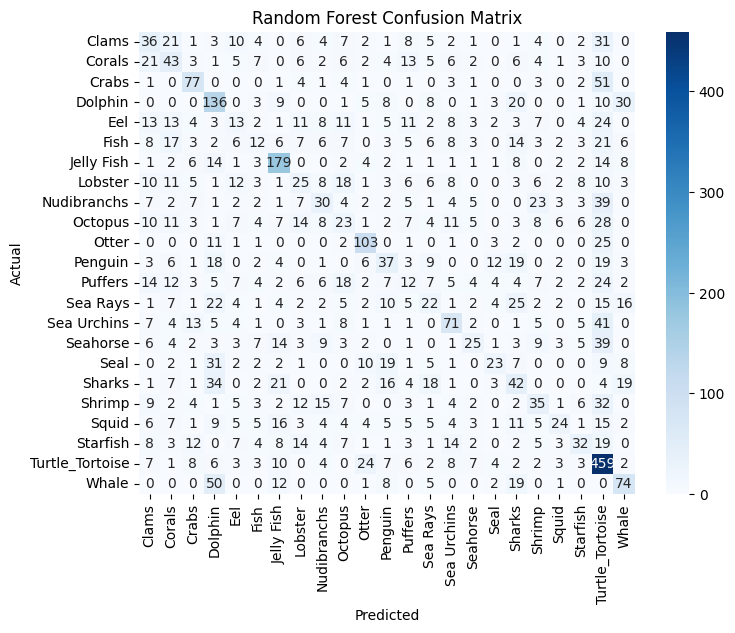

In [22]:
# Train ML models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

models = {
    "SVM": SVC(kernel='rbf'),
    "Random Forest": RandomForestClassifier(n_estimators=50),
    # "Gradient Boosting": GradientBoostingClassifier(n_estimators=50)
}

for name, model in models.items():
    print(f"🔹 Training {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [23]:
import joblib

joblib.dump(models["Random Forest"], "sea_animals_rf_model.pkl")

['sea_animals_rf_model.pkl']